# Inferring $R_t$ values from pyEpiabm using an SEIR model

In this notebook we use prevalence and incidence rates from pyEpiabm to infer the $\beta$, $\gamma$ and $\kappa$ values of the
SEIR model using `seirmo`. We then use $\beta$, $\gamma$ and $\kappa$  to calculate $R_t$ and then compare it to the true underlying
values.

## Plotting output data from the Northern Ireland simulation

This notebook takes data from the NI_example of pyEpiabm.

This simulation was run over 90 days with a total population of 1837198 and initial infected number of 100.

### SIR Plot for Northern Ireland

![SIR Plot](NI_outputs/r_0_2/SEIR.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pints

In [2]:
mpl.rcParams.update({'font.size': 15})

In [3]:
radius = "r_1"

In [ ]:
seir_data = pd.read_csv(f"NI_outputs/{radius}/inf_status_history.csv", dtype="int8", low_memory=False)
times = seir_data["time"]
# Get the true result from seir_data
susceptible_list = []
exposed_list = []
infected_list = []
recovered_list = []
for t in range(91):
    print(f"Day {t}")
    num = seir_data.iloc[t, 1:].value_counts().get(3, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(4, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(5, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(6, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(7, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(8, 0)
    susceptible_list.append(seir_data.iloc[t, 1:].value_counts().get(1, 0))
    exposed_list.append(seir_data.iloc[t, 1:].value_counts().get(2, 0))
    infected_list.append(num)
    recovered_list.append(seir_data.iloc[t, 1:].value_counts().get(9, 0) + seir_data.iloc[t, 1:].value_counts().get(10, 0))
susceptible = np.array(susceptible_list)
exposed = np.array(exposed_list)
infected = np.array(infected_list)
recovered = np.array(recovered_list)
plt.plot(times, infected)
plt.xlabel("Time")
plt.ylabel("Prevalence")
plt.title("Underlying prevalence for Northern Ireland simulation")

In [ ]:
plt.plot(times, infected)
plt.xlabel("Time")
plt.ylabel("Prevalence")
plt.title("Underlying prevalence for Ireland simulation, r = 0.2")

In [4]:
small_seir_df = pd.read_csv(f"NI_outputs/{radius}/seir.csv", index_col=0)
susceptible = small_seir_df["Susceptible"]
exposed = small_seir_df["Exposed"]
infected = small_seir_df["Infected"]
recovered = small_seir_df["Recovered"]

In [5]:
times = np.arange(0, len(susceptible), 1)

### Incidence into the E compartment

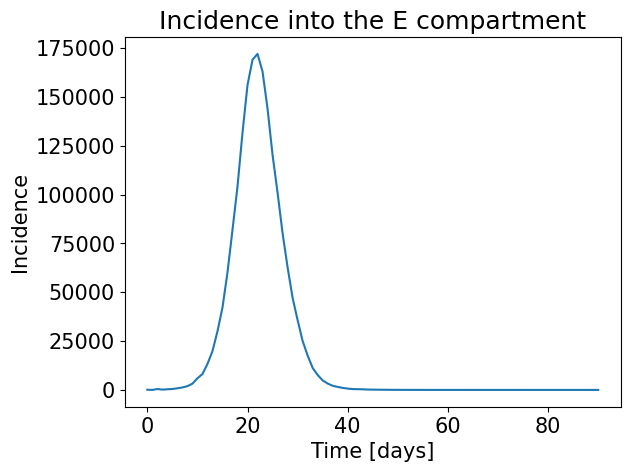

In [6]:
incidence_E = np.array([100] + (-np.diff(susceptible.to_numpy())).tolist())
plt.plot(times, incidence_E)
plt.xlabel("Time [days]")
plt.ylabel("Incidence")
plt.title("Incidence into the E compartment")
plt.savefig(f"NI_outputs/{radius}/incidence_E.png", bbox_inches="tight")

In [7]:
small_seir_df["Incidence (E)"] = incidence_E
small_seir_df.to_csv(f"NI_outputs/{radius}/seir.csv")

### Create $R_t$ plot

Simulations in pyEpiabm produce true $R_t$ values for each time step in a file named `secondary_infections.csv`. 

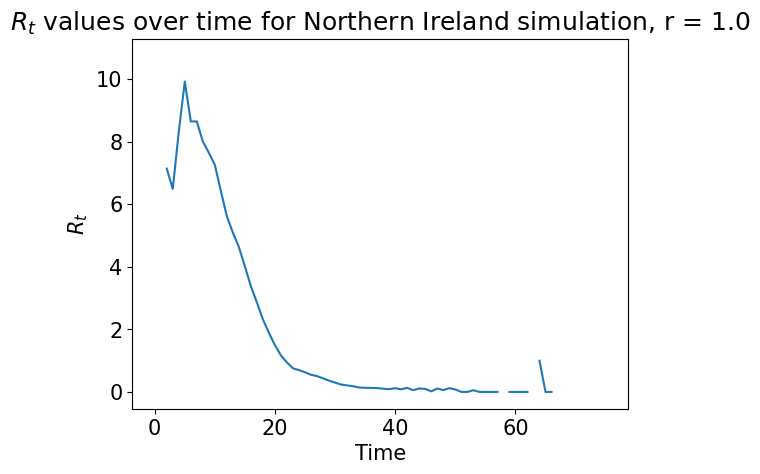

<Figure size 640x480 with 0 Axes>

In [8]:
secondary_infections_data = pd.read_csv(f"NI_outputs/{radius}/secondary_infections_E.csv", dtype="float32", low_memory=False)
plt.plot(secondary_infections_data["time"], secondary_infections_data["R_t"])
plt.xlabel("Time")
plt.ylabel("$R_t$")
plt.title("$R_t$ values over time for Northern Ireland simulation, r = 1.0")
plt.show()
plt.savefig(f"NI_outputs/{radius}/simulation_flow_R_t.png")

### Create secondary infections histogram

This file also contains data for the secondary infections of each person.

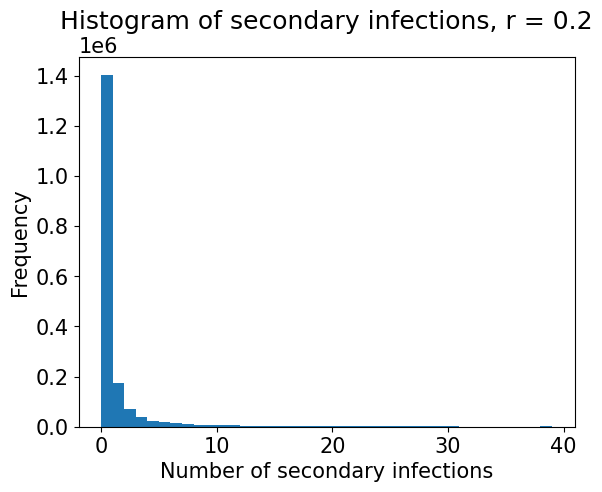

In [9]:
fig, ax = plt.subplots()
secondary_infections_data.dropna()
secondary_infections_only = secondary_infections_data.iloc[:, 2:-1].to_numpy()
secondary_infections_array = secondary_infections_only.flatten()
x_arr = np.arange(0, 40, 1)
ax.hist(secondary_infections_array, range=(0, 40), bins=x_arr, log=False)
ax.set_xlabel("Number of secondary infections")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of secondary infections, r = 0.2")
# plt.show()
fig.savefig(f"NI_outputs/{radius}/simulation_flow_secondary_infections.png", bbox_inches="tight")

### Serial interval histogram

In [10]:
# Create serial interval over time plot
serial_interval_df = pd.read_csv(f"NI_outputs/{radius}/serial_intervals.csv",
                                 index_col=0)

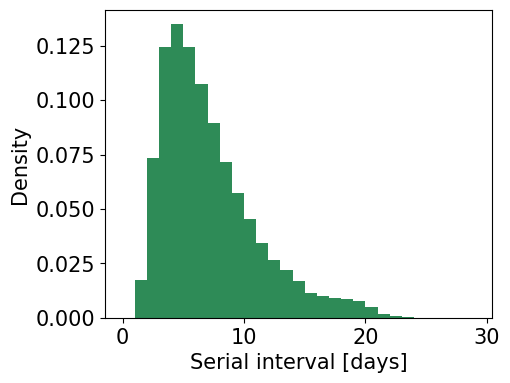

In [11]:
# Create serial interval histogram
serial_interval_df.dropna()
serial_interval_array = serial_interval_df.to_numpy().flatten()
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(serial_interval_array, density=True, range=(0, 30), log=False, color="seagreen", bins=np.arange(0, 30, 1))
ax.set_xlabel("Serial interval [days]")
ax.set_ylabel("Density")
# ax.set_title("Serial intervals")
# plt.show()
fig.savefig(f"NI_outputs/{radius}/simulation_flow_serial_intervals.png", bbox_inches="tight")

In [12]:
serial_interval_pdf = np.array([np.count_nonzero(serial_interval_array == i)
                                for i in range(91)]) / len(serial_interval_array[~np.isnan(serial_interval_array)])
# print(serial_interval_pdf)
# print(np.sum(serial_interval_pdf))

### Generation time histogram

In [13]:
# Create generation time over time plot
generation_time_df = pd.read_csv(f"NI_outputs/{radius}/generation_times.csv",
                                 index_col=0)

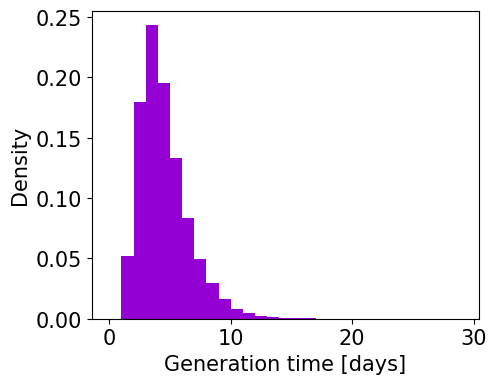

In [14]:
# Create generation time histogram
generation_time_df.dropna()
generation_time_array = generation_time_df.to_numpy().flatten()
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(generation_time_array, density=True, range=(0, 30), log=False, color="darkviolet", bins=np.arange(0, 30, 1))
ax.set_xlabel("Generation time [days]")
ax.set_ylabel("Density")
# ax.set_title("Serial intervals")
# plt.show()
fig.savefig(f"NI_outputs/{radius}/simulation_flow_generation_times.png", bbox_inches="tight")

In [15]:
generation_time_pdf = np.array([np.count_nonzero(generation_time_array == i)
                                for i in range(91)]) / len(generation_time_array[~np.isnan(generation_time_array)])
# print(serial_interval_pdf)
# print(np.sum(serial_interval_pdf))

### Serial intervals together with generation times

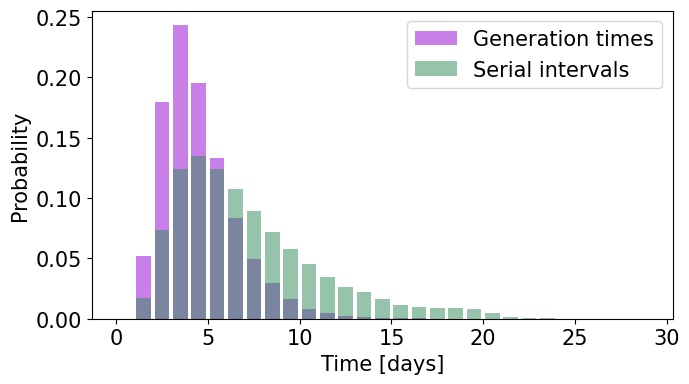

In [16]:
# Create histogram for both
fig, ax = plt.subplots(1, 1, figsize=(7.5, 4))
ax.hist(generation_time_array, density=True, range=(0, 30), log=False, color="darkviolet", label="Generation times", 
        alpha=0.5, bins=np.arange(0, 30, 1), rwidth=0.8)
ax.hist(serial_interval_array, density=True, range=(0, 30), log=False, color="seagreen", label="Serial intervals", 
        alpha=0.5, bins=np.arange(0, 30, 1), rwidth=0.8)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Probability")
ax.legend()
# ax.set_title("Serial intervals")
# plt.show()
fig.savefig(f"NI_outputs/{radius}/simulation_flow_si_and_gt.png", bbox_inches="tight")

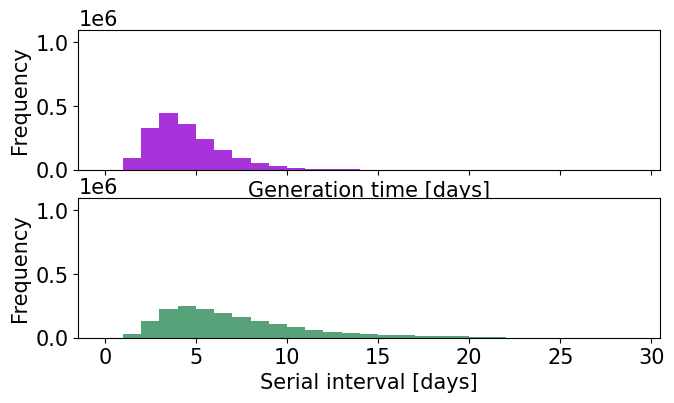

In [17]:
# Now on two different axes
fig, axs = plt.subplots(2, 1, figsize=(7.5, 4), sharex=True)
axs[0].hist(generation_time_array, range=(0, 30), log=False, color="darkviolet", alpha=0.8, bins=np.arange(0, 30, 1))
axs[0].set_ylim(0, 1.1e6)
axs[0].set_xlabel("Generation time [days]")
axs[1].hist(serial_interval_array, range=(0, 30), log=False, color="seagreen", alpha=0.8, bins=np.arange(0, 30, 1))
axs[1].set_ylim(0, 1.1e6)
axs[1].set_xlabel("Serial interval [days]")
axs[0].set_ylabel("Frequency")
axs[1].set_ylabel("Frequency")
# ax.set_title("Serial intervals")
# plt.show()
fig.savefig(f"NI_outputs/{radius}/simulation_flow_si_and_gt_twoax.png", bbox_inches="tight")

### Serial interval and generation time over time

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(0.0, 90.0, 1.0),
         np.nanmean(serial_interval_df.to_numpy()[:, :90], axis=0), label="Mean serial interval", color="seagreen")
ax.fill_between(np.arange(0.0, 90.0, 1.0),
                np.nanpercentile(serial_interval_df.to_numpy()[:, :90], 2.5, axis=0),
                np.nanpercentile(serial_interval_df.to_numpy()[:, :90], 97.5, axis=0), alpha=0.3, color="seagreen")
ax.plot(np.arange(0.0, 90.0, 1.0),
         np.nanmean(generation_time_df.to_numpy(), axis=0), label="Mean generation time", color="darkviolet")
ax.fill_between(np.arange(0.0, 90.0, 1.0),
                np.nanpercentile(generation_time_df.to_numpy(), 2.5, axis=0),
                np.nanpercentile(generation_time_df.to_numpy(), 97.5, axis=0), alpha=0.3, color="darkviolet")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
fig.savefig(f"NI_outputs/{radius}/simulation_flow_si_and_gt_over_time.png")

## Crude estimates for $\beta$, $\kappa$ and $\gamma$

In this section, we will use the governing ODEs:

\begin{equation}
    \frac{dS(t)}{dt} = -\frac{\beta}{N} S(t)I(t),
\end{equation}
\begin{equation}                \frac{dE(t)}{dt} =      \frac{\beta}{N} S(t)I(t) - \kappa E(t),
\end{equation}
\begin{equation}
    \frac{dI(t)}{dt} = \kappa E(t) - \gamma I(t), 
\end{equation}

\begin{equation}
    \frac{dR(t)}{dt} = \gamma I(t),
\end{equation}

to give crude estimates for what $\beta$, $\kappa$ and $\gamma$ should be as a comparison.

We will do this by estimating the gradients of the true compartmental values using `np.gradient` to retrieve an array
of estimates for $\beta$ (eq. 1) then $\gamma$ (eq. 4) and then $\kappa$ (eq. 3).

In [18]:
mpl.rcParams.update({'font.size': 11})

In [19]:
dS_dt = np.gradient(susceptible)
dE_dt = np.gradient(exposed)
dI_dt = np.gradient(infected)
dR_dt = np.gradient(recovered)

In [20]:
times = np.array([i for i in range(91)])

In [21]:
pop_size = 1837198
beta_estimate = - dS_dt * pop_size / (susceptible * infected)
gamma_estimate = dR_dt / infected
kappa_estimate_eq_3 = (dI_dt + gamma_estimate * infected) / exposed
kappa_estimate_eq_2 = (beta_estimate / pop_size * susceptible * infected - dE_dt) / exposed

In [22]:
epiabm_gamma, epiabm_kappa = 1/9.41, 1/4.59

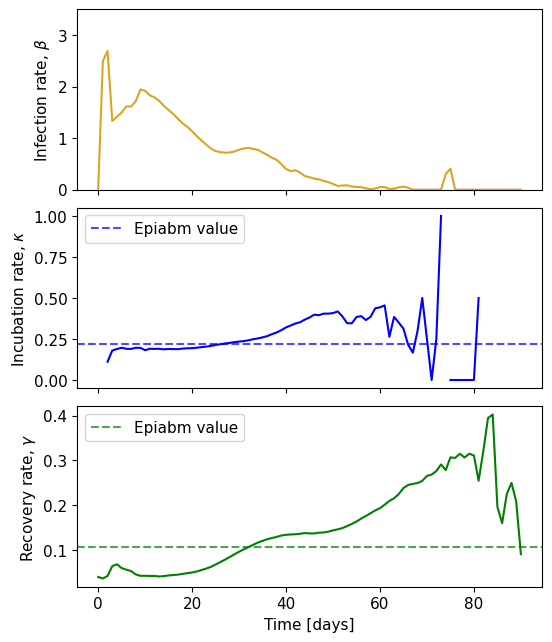

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 7.5), sharex=True)
axs[0].plot(times, beta_estimate, color="goldenrod")
axs[0].set_ylabel("Infection rate, $\\beta$")
axs[1].plot(times, kappa_estimate_eq_3, color="blue")
axs[1].axhline(epiabm_kappa, color="blue", alpha=0.7, linestyle="--", label="Epiabm value")
axs[1].set_ylabel("Incubation rate, $\\kappa$")
axs[1].legend()
axs[2].plot(times, gamma_estimate, color="green")
axs[2].axhline(epiabm_gamma, color="green", alpha=0.7, linestyle="--", label="Epiabm value")
axs[2].set_ylabel("Recovery rate, $\\gamma$")
axs[2].set_xlabel("Time [days]")
axs[2].legend()
axs[0].set_ylim(0, 3.5)
fig.subplots_adjust(hspace=0.1)
# plt.title("Crude estimates")
# fig.suptitle("Time-varying estimates for the SEIR model parameters")
fig.savefig(f"NI_outputs/{radius}/crude_estimates.png", bbox_inches="tight")

In [24]:
mpl.rcParams.update({'font.size': 15})

In [25]:
param_df = pd.DataFrame({"beta": beta_estimate, "gamma": gamma_estimate, "kappa_eq_3": kappa_estimate_eq_3,
                         "kappa_eq_2": kappa_estimate_eq_2})
param_df.replace(np.inf, 0, inplace=True)
beta_estimate, gamma_estimate, kappa_estimate_eq_3, kappa_estimate_eq_2 = param_df["beta"], param_df["gamma"], param_df["kappa_eq_2"], param_df["kappa_eq_3"]
# We replace any zeros with NaNs as these will not contribute to the beta, gamma and kappa values
param_df.replace(0, np.nan, inplace=True)
print(f"Mean beta: {np.mean(beta_estimate)}, std dev beta: {np.std(beta_estimate)}")
print(f"Mean gamma: {np.mean(gamma_estimate)}, std dev gamma: {np.std(gamma_estimate)}")
print(f"Mean kappa (eq 2): {np.mean(kappa_estimate_eq_2)}, std dev kappa (eq 2): {np.std(kappa_estimate_eq_2)}")
print(f"Mean kappa (eq 3): {np.mean(kappa_estimate_eq_3)}, std dev kappa (eq 3): {np.std(kappa_estimate_eq_3)}")

Mean beta: 0.7626132760045915, std dev beta: 0.6729028390938536
Mean gamma: 0.15181968555984324, std dev gamma: 0.09306306854428105
Mean kappa (eq 2): 0.29198182742866463, std dev kappa (eq 2): 0.12550132640488054
Mean kappa (eq 3): 0.2919818274286646, std dev kappa (eq 3): 0.1255013264048805


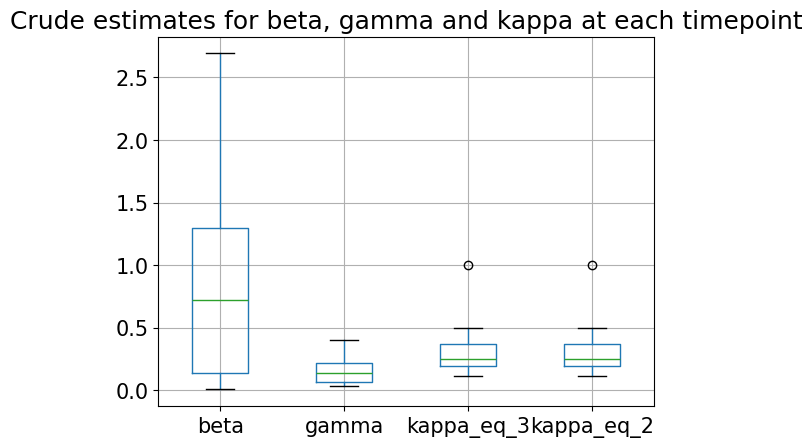

In [26]:
param_df.boxplot()
plt.title("Crude estimates for beta, gamma and kappa at each timepoint")
plt.savefig(f"NI_outputs/{radius}/crude_estimates_boxplot.png")

### Crude estimate of $R_t$

Now we will move on to estimating the value of $R_t$. The effective reproduction number, $R_t$, is defined as:

$$R_{t} = \frac{\beta(t)}{N\gamma(t)}S(t),$$

where $\beta(t)$ and $\gamma(t)$ are as defined previously, $N$ is the total population and $S(t)$ is the number of susceptible people at time $t$.

In [ ]:
crude_R_t = param_df['beta'] * susceptible / (pop_size * param_df['gamma'])
mean_crude_R_t = np.mean(param_df['beta']) * susceptible / (pop_size * np.mean(param_df['gamma']))

In [ ]:
plt.plot(times, crude_R_t, label='Crude estimate')
plt.plot(times, mean_crude_R_t, label='Crude estimate using means')
plt.plot(times, secondary_infections_data['R_t'], label='True values')
plt.xlabel("Time")
plt.ylabel("R_t")
plt.legend()
plt.title("Comparing crude estimate of $R_t$ to the true curve")
plt.savefig(f"NI_outputs/{radius}/crude_R_t.png")

## Model Inference

### Set up

First, we normalise the data. Here is a description of our parameters:
* $S(0)$, $E(0)$, $I(0)$, $R(0)$ - Initial $S$, $E$, $I$ and $R$ values
* $\beta$, $\kappa$, $\gamma$ - Infection Rate, Incubation Rate and Recovery Rate respectively
* $\sigma_{S}$, $\sigma_{E}$, $\sigma_{I}$, $\sigma_{R}$ - The 4 $\sigma$ parameters for the auto-regressive log-likelihood
* $\rho_{S}$, $\rho_{E}$, $\rho_{I}$, $\rho_{R}$ - The 4 $\rho$ parameters for the auto-regressive log-likelihood

In [27]:
all_data = np.array([susceptible, exposed, infected, recovered]).transpose()
pop_size = 1837198
# initial_infected = 100
initial_infected = all_data[0, 2]
# S0, E0, I0, R0 = all_data[5, 0], all_data[5, 1], all_data[5, 2], all_data[5, 3]
all_data = all_data / pop_size

### PINTS ForwardModel

Next, we create the forward model used to perform inference. We will be using a `ReducedModel` from `seirmo` to fix/specify specific parameters
to reduce the dimensions of the parameter space. These values are described in the table below. We will change which ones we fix depending on the analysis.

|Parameter|Value|Reasoning|
|---|---|-------|
|$S(0)$|$1 - I(0)$|The total of all compartments must add up to $1$ for all time (after scaling out by `pop_size`).|
|$E(0)$|$0$|We can safely assume that no-one has been exposed at the start of the simulation.|
|$I(0)$|$\frac{100}{1837198}$|We know that there were $100$ initial infected, and we scale out by `pop_size`.|
|$R(0)$|$0$|We also enforce that no-one has recovered at the start of the simulation.|
|$\kappa$|$\frac{1}{4.59}$|This is the underlying value from Epiabm.|
|$\gamma$|$\frac{1}{9.41}$|This is the underlying value from Epiabm.|

In [28]:
import seirmo
import pints

class SEIRModel(pints.ForwardModel):
    def __init__(self, pop_size, initial_infected, fixed_hyperparams=None, prevalence=False,
                 S0=None, E0=None, R0=None, sampling_intervals=None):
        """
        Creates the SEIR model, with options to fix parameters, use prevalence only, and sample various time intervals
        of the epidemic.
        """

        super(SEIRModel, self).__init__()

        seir_model = seirmo.SEIRModel()
        self._model = seirmo.ReducedModel(seir_model)
        fixed_parameters = {"S0": 1 - initial_infected / pop_size, "E0": 0, "I0": initial_infected / pop_size, "R0": 0}
        if S0:
            fixed_parameters = {"S0": S0 / pop_size, "E0": E0 / pop_size, "I0": I0 / pop_size, "R0": R0 / pop_size}
        self._fixed_hyperparams = fixed_hyperparams
        if fixed_hyperparams is not None:
            fixed_parameters = fixed_hyperparams | fixed_parameters
        self._model.fix_parameters(fixed_parameters)
        self._n_outputs = 1 if prevalence else 4
        # sampling_intervals is a list of tuple pairs denoting the start and end timepoints
        # for which to take a sample (to mimic the REACT-1 survey), for example, missing
        # every week
        self._sampling_intervals = sampling_intervals

    def n_outputs(self):
        # Returns number of model outputs.
        # Returns the S, E, I and R values at each timestep
        return self._n_outputs

    def n_parameters(self):
        # Returns number of parameters, i.e. some of beta, kappa and gamma
        return 3 - len(self._fixed_hyperparams)

    def n_fixed_parameters(self):
        # Returns number of fixed parameters, i.e. 4 initial conditions (S(0), E(0), I(0) and R(0)) and potentially other ones
        return self._n_outputs + len(self._fixed_hyperparams)

    def simulate(self, parameters, sampled_times):
        # This ensures that we are taking the prevalence
        if self._n_outputs == 4:
            self._model.set_outputs(["S", "E", "I", "R"])
        else:
            self._model.set_outputs(["I"])
        # We want to ensure that we are simulating for all times and then afterwards take the sample
        # times = np.arange(sampled_times[0], sampled_times[-1] + 1, 1)
        # In case we wish to use a different times array
        # times = np.arange(0, len(susceptible), 0.01)
        compartmental_results = self._model.simulate(parameters=parameters, times=times)
        # compartmental_results = compartmental_results[::100]
        if self._sampling_intervals:
            compartmental_lists = [compartmental_results[pair[0]:pair[1]] for pair in sampling_intervals]
            compartmental_results = np.array([result for result_list in compartmental_lists for result in result_list])
        return compartmental_results

In [29]:
trial = "bgk_AR1_prev_10"

Note that in seirmo $\kappa$ is called "beta"

In [30]:
prevalence = True

In [31]:
# In case we want to use sampling intervals
sampling_intervals = None
# This represents where we take a sample for 2 weeks and then miss a week in between
# sampling_intervals = [(0, 14), (21, 35), (42, 56), (63, 77), (84, 91)]
# This represents where we take a sample for 2 weeks and then miss 2 weeks in between
# sampling_intervals = [(0, 14), (28, 42), (56, 70), (84, 91)]
# This represents where we take a sample for 3 weeks and then miss 1 week in between
# sampling_intervals = [(0, 21), (28, 49), (56, 77), (84, 91)]
# This represents where we take a sample for 1 week and then miss 3 weeks in between
# sampling_intervals = [(0, 7), (28, 35), (56, 63), (84, 91)]

In [32]:
fixed_hyperparams = {}
# fixed_hyperparams = {"gamma": 1/9.41, "beta": 1/4.59}
# fixed_hyperparams = {"gamma": 0.0943, "beta": 0.2193}
# fixed_hyperparams = {"gamma": 0.105, "beta": 0.279}
# fixed_hyperparams = {"gamma": 0.152, "beta": 0.292}
# fixed_hyperparams = {"gamma": 0.173, "beta": 0.283}
# fixed_hyperparams = {"gamma": 0.149, "beta": 0.267}
all_data = all_data if not prevalence else all_data[:, 2]
pints_model = SEIRModel(pop_size=pop_size, initial_infected=initial_infected,
                        fixed_hyperparams=fixed_hyperparams, prevalence=prevalence,
                        sampling_intervals=sampling_intervals)
# pints_model = SEIRModel(pop_size=pop_size, initial_infected=I0,
#                         fixed_hyperparams=fixed_hyperparams, prevalence=prevalence,
#                         S0=S0, E0=E0, R0=R0)
if sampling_intervals:
    time_lists = [times[pair[0]:pair[1]] for pair in sampling_intervals]
    truncated_times = np.array([time for time_list in time_lists for time in time_list])
    data_lists = [all_data[pair[0]:pair[1]] for pair in sampling_intervals]
    truncated_data = np.array([data for data_list in data_lists for data in data_list])
else:
    truncated_times = times[:]
    truncated_data = all_data[:]
problem = pints.MultiOutputProblem(pints_model, truncated_times, truncated_data)

### Optimisation

We now will use the optimiser to reach some realistic parameter values.

In [ ]:
# boundaries = pints.RectangularBoundaries([0.01, 0.01, 0.01],
#                                          [10, 1, 1])
boundaries = pints.RectangularBoundaries([0.01],
                                         [10])
log_prior = pints.UniformLogPrior(boundaries)

In [ ]:
# composed_log_prior = pints.ComposedLogPrior(
#     log_prior,
#     pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
#     pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
#     pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
#     pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf)
# )
composed_log_prior = pints.ComposedLogPrior(
    log_prior, # beta, kappa and gamma
    # pints.UniformLogPrior(0, 1), # rho_S
    # pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf), # sigma_S
    # pints.UniformLogPrior(0, 1), # rho_E
    # pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf), # sigma_E
    pints.UniformLogPrior(0, 1), # rho_I
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf), # sigma_I
    # pints.UniformLogPrior(0, 1), # rho_R
    # pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf) # sigma_R
)
# composed_boundaries = pints.RectangularBoundaries([0.01, 0.01, 0.01, 0, 0, 0, 0],
#                                                   [4, 4, 4, 4, 4, 4, 4])
# composed_boundaries = pints.RectangularBoundaries([0.01, 0.01, 0, 0, 0, 0],
#                                                   [4, 4, 4, 4, 4, 4])
# composed_boundaries = pints.RectangularBoundaries([0.01, 0, 0, 0, 0],
#                                                   [4, 4, 4, 4, 4])
# composed_boundaries = pints.RectangularBoundaries([0.01, 0.01, 0.01, 0, 0],
#                                                   [10, 1, 1, 4, 4])
# composed_boundaries = pints.RectangularBoundaries([0.01, 0.01, 0.01, 0, 0, 0, 0, 0, 0, 0, 0],
#                                                   [10, 1, 1, 1, 4, 1, 4, 1, 4, 1, 4])
composed_boundaries = pints.RectangularBoundaries([0.01, 0, 0],
                                                  [10, 4, 4])
# composed_boundaries = pints.RectangularBoundaries([0.01, 0.01, 0.001, 0, 0],
#                                                   [4, 1, 0.5, 1, 4])

In [ ]:
num_opts = 10
# Create log-likelihood
log_likelihood = pints.AR1LogLikelihood(problem)
# param_names = ["beta", "kappa", "gamma",
#                "sigma_S", "sigma_E", "sigma_I", "sigma_R"]
# param_names = ["beta", "kappa",
#                "sigma_S", "sigma_E", "sigma_I", "sigma_R"]
# param_names = ["beta",
#                "sigma_S", "sigma_E", "sigma_I", "sigma_R"]
param_names = ["beta", "rho_I", "sigma_I"]
# param_names = ["beta", "kappa", "gamma",
#                "rho_I", "sigma_I"]
# param_names = ["beta", "kappa", "gamma",
#                "rho_S", "sigma_S", "rho_E", "sigma_E", "rho_I", "sigma_I", "rho_R", "sigma_R"]

In [ ]:
for j in range(num_opts):
    print(f"Iteration {j}")
    xs = composed_log_prior.sample(1)
    opt = pints.OptimisationController(log_likelihood, xs, boundaries=composed_boundaries, method=pints.CMAES)
    opt.set_max_unchanged_iterations(200, 0.00000001)
    opt.set_max_iterations(2500)
    opt_params, opt_values = opt.run()
    opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(len(param_names))})
    opt_param_df.to_csv(f"optimisation_outputs/{radius}/{trial}/opt_params_{j}.csv")

### Plotting with optimised parameters 

In [ ]:
opt_params = []
num_opts = 10
for j in range(num_opts):
    opt_param_df = pd.read_csv(f"optimisation_outputs/{radius}/{trial}/opt_params_{j}.csv", index_col=0)
    opt_params.append(opt_param_df.to_numpy()[0])

In [ ]:
errors = []
# true_error = score(parameters)
# print("---------------------------------------------------------------------------")
# print(f"True parameters, sum of squared errors = {round(true_error, 5)}")
for j in range(num_opts):
    print("---------------------------------------------------------------------------")
    error = log_likelihood(opt_params[j])
    print(f"Optimisation {j}, log-likelihood = {round(error, 5)}")
    print("---------------------------------------------------------------------------")
    errors.append(error)
    output_list = []
    for i in range(pints_model.n_parameters()):
        opt_param = round(opt_params[j][i], 5)
        output_list.append(opt_param)
        print(f"Parameter: {param_names[i]}, Optimised: {opt_param}")

In [ ]:
chosen_opt = 9

In [ ]:
num_params = pints_model.n_parameters()
for i in range(10):
    opt_soln = pints_model.simulate(opt_params[i][:num_params], truncated_times)
    # opt_soln = model.simulate(parameters, times)

    # opt_S, opt_E, opt_I, opt_R = opt_soln[:, 0], opt_soln[:, 1], opt_soln[:, 2], opt_soln[:, 3]
    opt_I = opt_soln
    plt.plot(truncated_times, opt_I, "-r", label="Optimised")
plt.plot(times, infected[:] / pop_size, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [days]")
plt.ylabel("Population")
plt.legend()
plt.title(f"Infected population for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/{radius}/{trial}/infected_{chosen_opt}.png")

In [ ]:
num_params = pints_model.n_parameters()
opt_soln = pints_model.simulate(opt_params[chosen_opt][:num_params], truncated_times)
# opt_soln = model.simulate(parameters, times)

# opt_S, opt_E, opt_I, opt_R = opt_soln[:, 0], opt_soln[:, 1], opt_soln[:, 2], opt_soln[:, 3]
opt_I = opt_soln
# opt_V = opt_soln[:, 0]
plt.plot(truncated_times, opt_I, "-r", label="Optimised")
plt.plot(truncated_times, susceptible / pop_size, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [days]")
plt.ylabel("Population")
plt.legend()
plt.title(f"Susceptible population for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/r_1/{trial}/susceptible_{chosen_opt}.png")

In [ ]:
plt.plot(times, opt_E, "-r", label="Optimised")
plt.plot(times, exposed / pop_size, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [days]")
plt.ylabel("Population")
plt.legend()
plt.title(f"Exposed population for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/r_1/{trial}/exposed{chosen_opt}.png")

In [ ]:
plt.plot(times, opt_I, "-r", label="Optimised")
plt.plot(times, infected / pop_size, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [days]")
plt.ylabel("Population")
plt.legend()
plt.title(f"Infected population for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/r_1/{trial}/infected_{chosen_opt}.png")

In [ ]:
plt.plot(times, opt_R, "-r", label="Optimised")
plt.plot(times, recovered / pop_size, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [days]")
plt.ylabel("Population")
plt.legend()
plt.title(f"Recovered population for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/r_1/{trial}/recovered_{chosen_opt}.png")

### PINTS `MultiOutputProblem` and `GaussianLogLikelihood`

We choose a Gaussian log-likelihood and an array of Gaussian log-priors for each of the different parameters of the model.

In [ ]:
# Create log-prior and log-posterior
log_posterior = pints.LogPosterior(log_likelihood, composed_log_prior)

### Initialising multiple starting locations for the chain

We put starting locations for 4 chains near the optimised parameter set.

In [ ]:
num_chains = 4
xs = np.vstack([opt_params[chosen_opt] * 1.0,
                opt_params[chosen_opt] * 0.7,
                opt_params[chosen_opt] * 0.3,
                opt_params[chosen_opt] * 0.2])
# other_opt = 1
# xs = np.vstack([opt_params[chosen_opt],
#                 opt_params[chosen_opt] * 1.1,
#                 opt_params[chosen_opt] * 1.1,
#                 opt_params[chosen_opt]])
print(xs)
# transform = pints.RectangularBoundariesTransformation([0.01, 0.01, 0.01, 0, 0, 0, 0],
#                                                       [4, 4, 4, 1, 1, 1, 1])
# transform = pints.RectangularBoundariesTransformation([0.01, 0, 0, 0, 0],
#                                                       [10, 1, 1, 1, 1])
# transform = pints.RectangularBoundariesTransformation([0.01, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                                                       [10, 1, 1, 1, 4, 1, 4, 1, 4, 1, 4])
transform = pints.RectangularBoundariesTransformation([0.01, 0, 0],
                                                      [10, 1, 4])
# transform = pints.RectangularBoundariesTransformation([0.01, 0.01, 0.001, 0, 0],
#                                                       [4, 1, 0.5, 1, 1])

### Performing inference

In [ ]:
n_params = log_prior.n_parameters()
mcmc = pints.MCMCController(log_posterior, num_chains, xs, transformation=transform)
max_iterations = 80000
mcmc.set_max_iterations(max_iterations)
mcmc.set_initial_phase_iterations(1000)
# This is to try and get more of a spread in the initial phase
sigma0_multiplier = None
# sigma0_multiplier = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
# sigma0_multiplier = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
# sigma0_multiplier = np.array([0.1, 0.1])
if sigma0_multiplier is not None:
    for s in mcmc.samplers():
        s._sigma = np.diag(s._sigma.dot(sigma0_multiplier))

chains = mcmc.run()

### Saving chains

In [33]:
trial = "bgk_AR1_prev_10"

In [34]:
param_names = ['Infection Rate (beta)', 'Incubation Rate (kappa)', 'Recovery Rate (gamma)',
               'rho_I', 'sigma_I']
# param_names = ['Infection Rate (beta)',
#                'rho_I', 'sigma_I']
# param_names = ['Infection Rate (beta)', 'Incubation Rate (kappa)', 'Recovery Rate (gamma)',
#                "rho_S", "sigma_S", "rho_E", "sigma_E", "rho_I", "sigma_I", "rho_R", "sigma_R"]
# param_names = ['Infection Rate (beta)', 'Incubation Rate (kappa)',
#                'sigma_S', 'sigma_E', 'sigma_I', 'sigma_R']
# param_names = ['Infection Rate (beta)',
#                'sigma_S', 'sigma_E', 'sigma_I', 'sigma_R']

In [ ]:
# for i, chain in enumerate(chains):
#     df = pd.DataFrame(chain, columns=param_names)
#     df.to_csv(f"chain_data/{radius}/{trial}/chain_{i}.csv")

## Plots

### Recovering chains from .csv files

In [35]:
list_of_chains = []
for i in range(4):
    df = pd.read_csv(f"chain_data/{radius}/{trial}/chain_{i}.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

### Trace plots

In [36]:
mpl.rcParams.update({'font.size': 11})

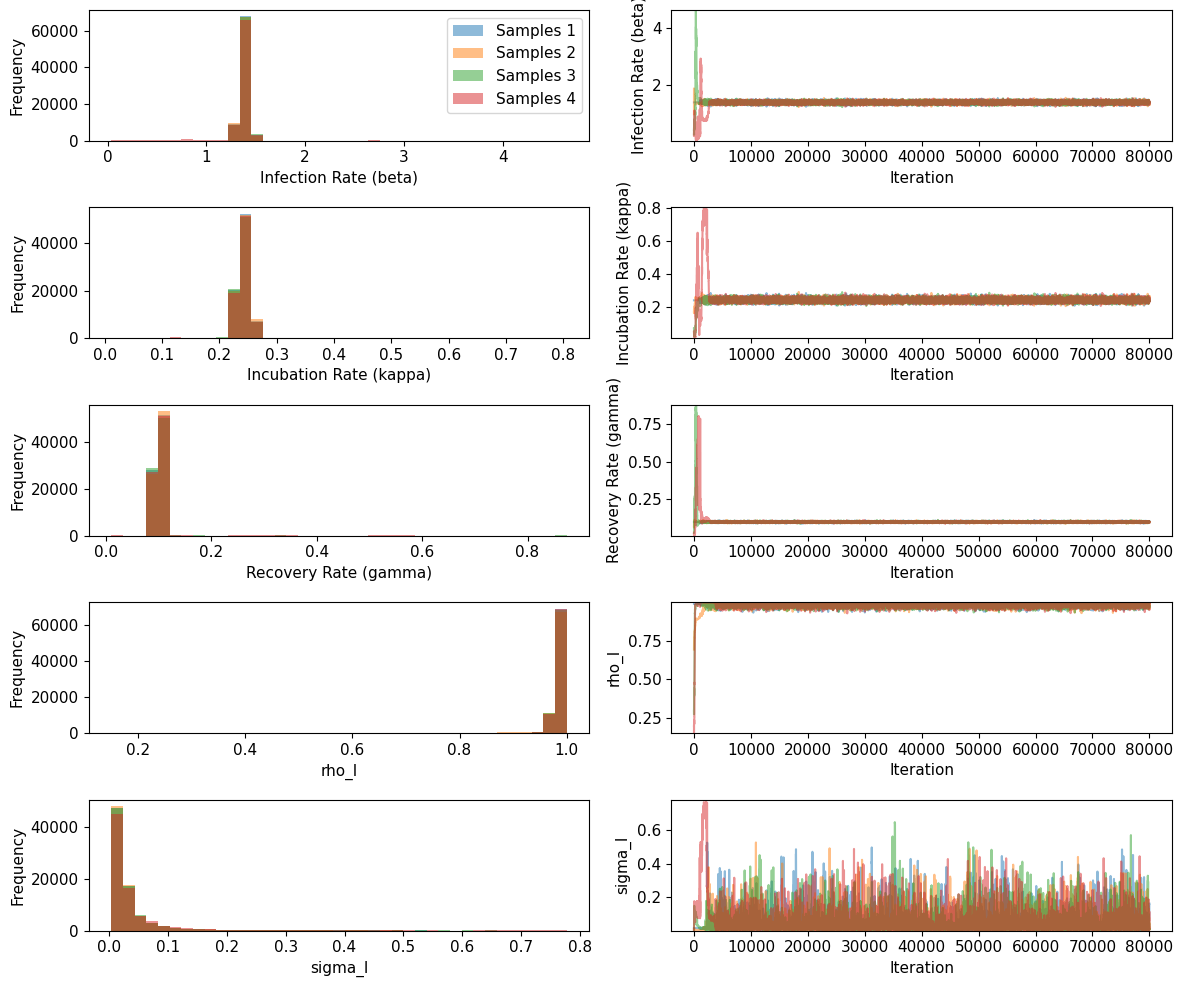

In [37]:
import pints.plot
pints.plot.trace(chains, parameter_names=param_names)
plt.show()

### Diagnosing using $\hat{R}$

Here we find the $\hat{R}$ measure for the inference for all different parameters. For well mixed and stationary chains, $\hat{R}$ is close to $1$.

In [38]:
r_hat_values = pints.rhat(chains, warm_up=0.5)
for i in range(len(param_names)):
    print(f"R_hat value for {param_names[i]}: {round(r_hat_values[i], 5)}")

R_hat value for Infection Rate (beta): 1.00025
R_hat value for Incubation Rate (kappa): 1.00033
R_hat value for Recovery Rate (gamma): 1.00044
R_hat value for rho_I: 1.00015
R_hat value for sigma_I: 1.00033


We will now discount the first half of the iterations.

In [39]:
max_iterations = 80000
chains = chains[:, int(max_iterations / 2):]

### Predicted time series plots

#### Chain 1

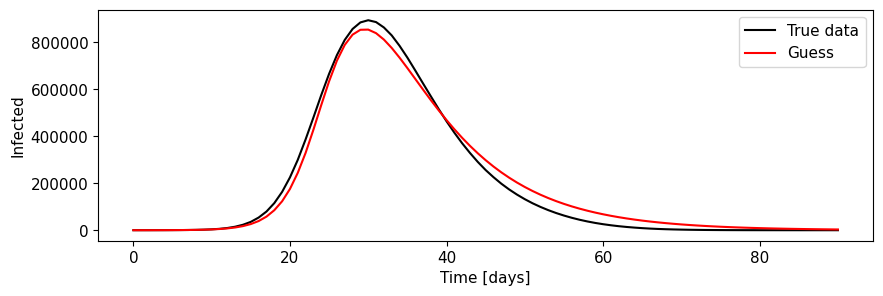

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(times, infected, label='True data', color='black')
ax.plot(times, pints_model.simulate(chains[0, 0][:3], times) * pop_size, label='Guess', color='red')
ax.legend()
ax.set_xlabel('Time [days]')
ax.set_ylabel('Infected')
fig.savefig(f"inference_outputs/{radius}/{trial}/example.png", bbox_inches='tight')

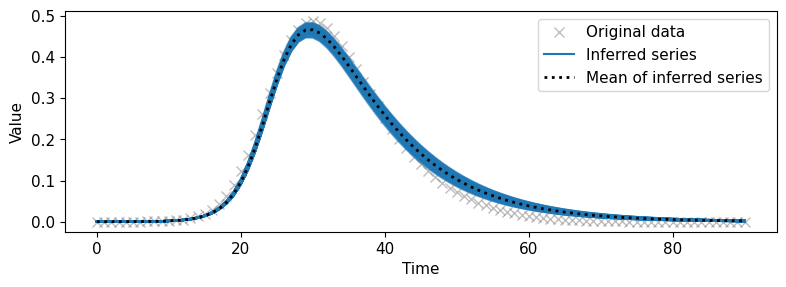

In [41]:
pints.plot.series(chains[0, :], problem)
plt.show()

#### Chain 2

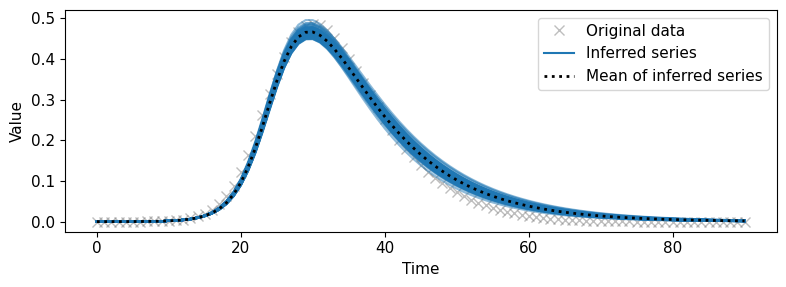

In [42]:
pints.plot.series(chains[1, :], problem)
plt.show()

#### Chain 3

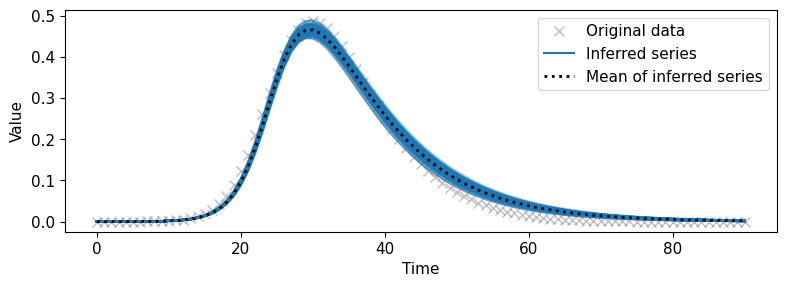

In [43]:
pints.plot.series(chains[2, :], problem)
plt.savefig(f"inference_outputs/{radius}/{trial}/series.png")

#### Chain 4

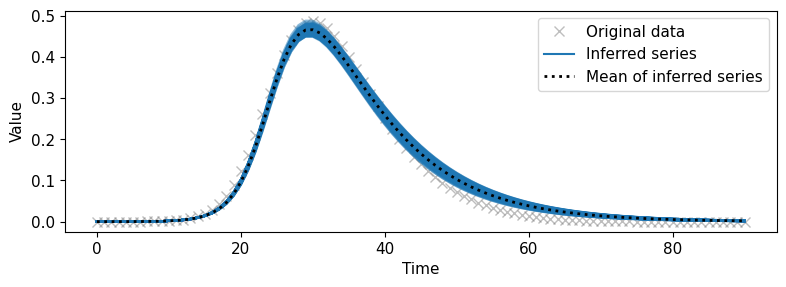

In [44]:
pints.plot.series(chains[3, :], problem)
plt.show()

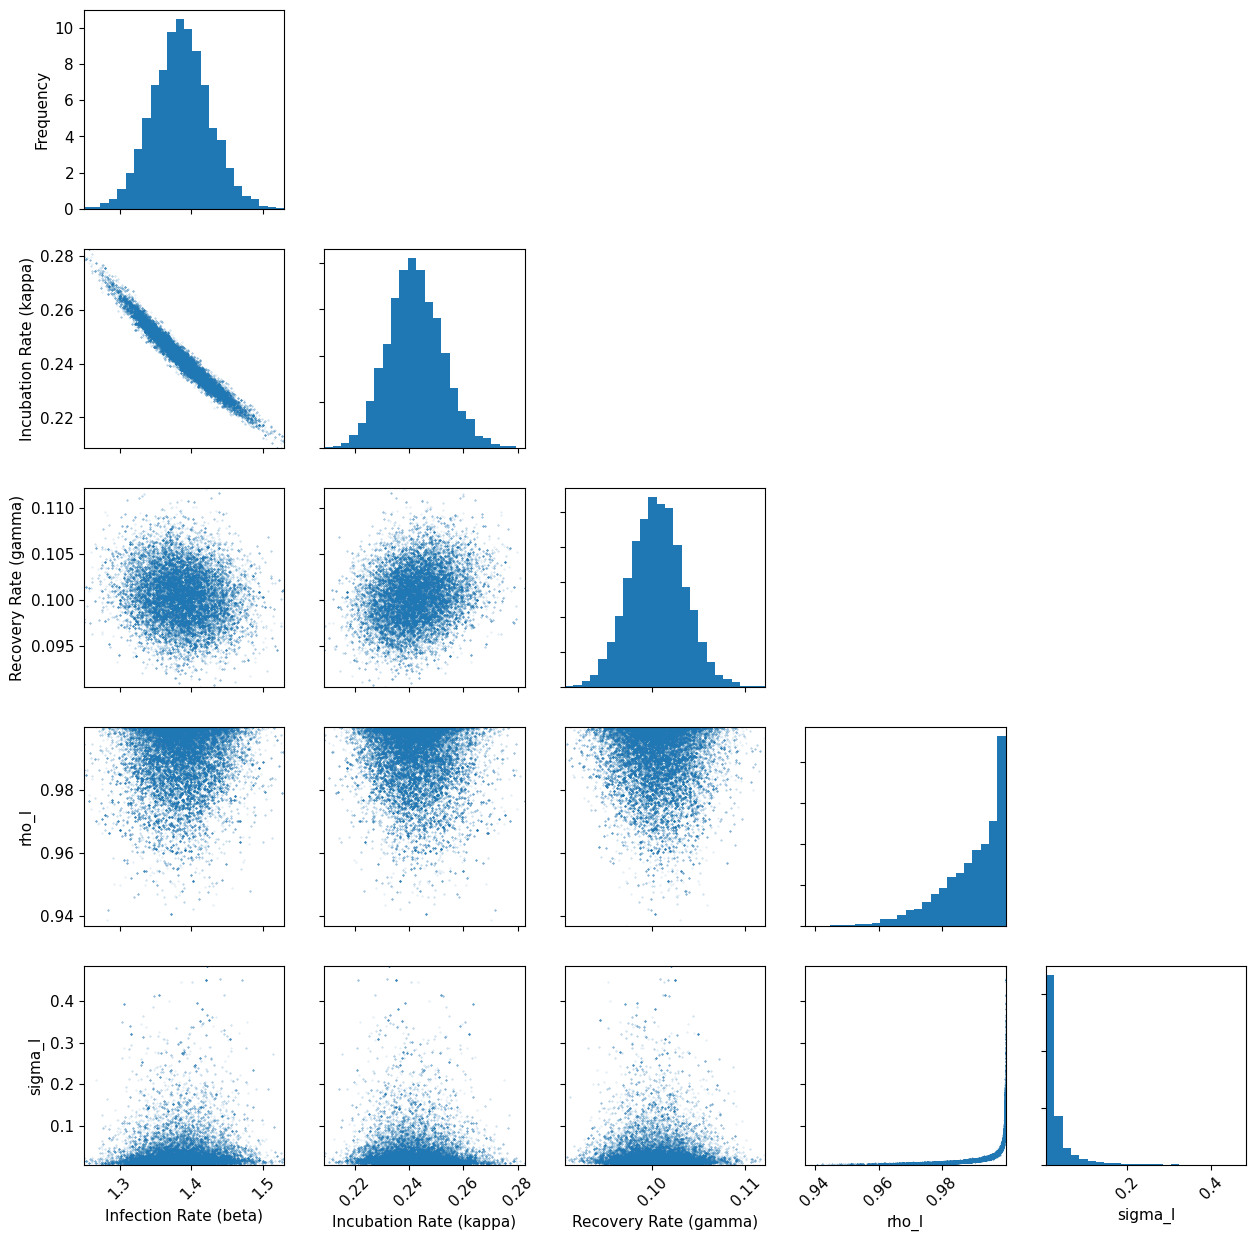

In [45]:
pints.plot.pairwise(chains[0, :], parameter_names=param_names)
plt.savefig(f"inference_outputs/{radius}/{trial}/pairwise.png")

### Plotting autocorrelations

In this model, if the data were generated via a Gaussian noise process, we would see the autocorrelation plots lying within the threshold.

In [46]:
mpl.rcParams.update({'font.size': 12.5})

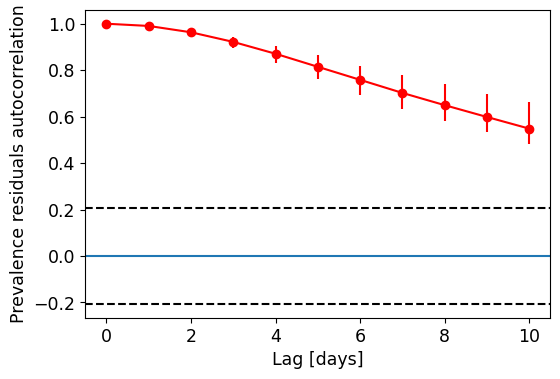

In [47]:
import pints.residuals_diagnostics
pints.residuals_diagnostics.plot_residuals_autocorrelation(chains[0, :], problem)
plt.xlabel("Lag [days]")
plt.ylabel("Prevalence residuals autocorrelation")
# plt.legend()
plt.savefig(f"inference_outputs/{radius}/{trial}/autocorrelation.png", bbox_inches="tight")

In [48]:
mpl.rcParams.update({'font.size': 12.5})

## Estimating $R_t$

Now we will move on to estimating the value of $R_t$. The effective reproduction number, $R_t$, is defined as:

$$R_{t} = \frac{\beta}{\gamma N}S(t),$$

where $\beta$ and $\gamma$ are as defined previously, $N$ is the total population and $S(t)$ is the number of susceptible people at time $t$.

### Rescaling and extracting $\beta$ and $\gamma$

In [49]:
param_names = ["Infection Rate ($\\beta$)", "Incubation Rate ($\\kappa$)", "Recovery Rate ($\\gamma$)", "rho_I", "sigma_I"]
# param_names = ["Infection Rate (beta)", "Incubation Rate (kappa)", "sigma_S", "sigma_E", "sigma_I", "sigma_R"]
# param_names = ["Infection Rate (beta)", "sigma_S", "sigma_E", "sigma_I", "sigma_R"]
# param_names = ["Infection Rate ($\\beta$)", "rho_I", "sigma_I"]
# param_names = ["Infection Rate ($\\beta$)", "Incubation Rate ($\\kappa$)", "Recovery Rate ($\\gamma$)",
#                "rho_S", "sigma_S", "rho_E", "sigma_E", "rho_I", "sigma_I", "rho_R", "sigma_R"]
chains_df = pd.DataFrame(columns=param_names + ['chain'])
for i in range(4):
    chain_i_df = pd.DataFrame(chains[i], columns=param_names)
    # for population_parameter in ["sigma_S", "sigma_E", "sigma_I", "sigma_R"]:
    for population_parameter in ["sigma_I"]:
        chain_i_df[population_parameter] = pop_size * chain_i_df[population_parameter]
    chain_i_df['chain'] = [i] * len(chain_i_df)
    chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_16428\3309456687.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)


In [50]:
epiabm_params = [1/9.41, 1/4.59]

Mean beta: 1.385248602487014, std dev beta: 0.03954966846848292
Mean gamma: 0.10046266633743928, std dev gamma: 0.0029315123649630804
Mean kappa: 0.2422433920063352, std dev kappa: 0.010045655909770353


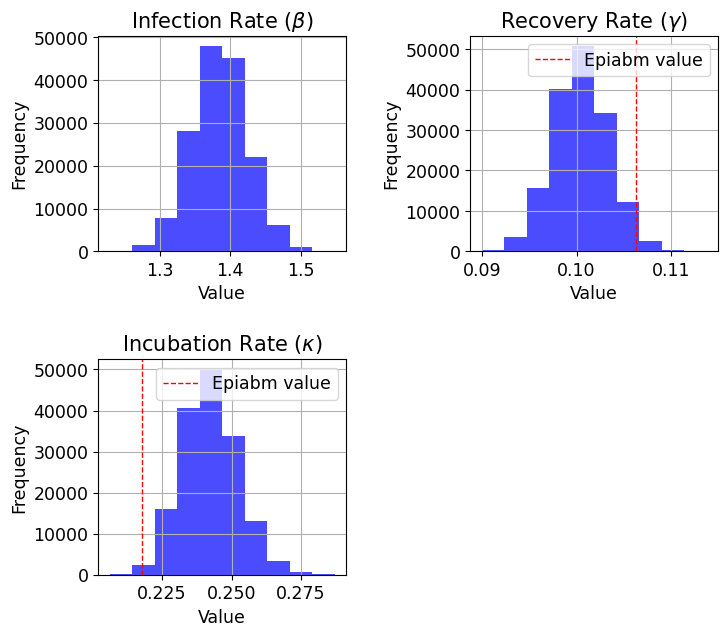

In [51]:
beta_posterior = chains_df["Infection Rate ($\\beta$)"].to_numpy()
gamma_posterior = chains_df["Recovery Rate ($\\gamma$)"].to_numpy()
kappa_posterior = chains_df["Incubation Rate ($\\kappa$)"].to_numpy()
print(f"Mean beta: {np.mean(beta_posterior)}," 
      f" std dev beta: {np.std(beta_posterior)}")
print(f"Mean gamma: {np.mean(gamma_posterior)}," 
      f" std dev gamma: {np.std(gamma_posterior)}")
print(f"Mean kappa: {np.mean(kappa_posterior)}," 
      f" std dev kappa: {np.std(kappa_posterior)}")
num_rows, num_columns = 2, 2
num_params = 3
# crude_param_names = ["beta"]
# histograms = chains_df.hist(column=["Infection Rate ($\\beta$)"],
#                             color="blue", alpha=0.7, figsize=(5, 4))
histograms = chains_df.hist(column=["Infection Rate ($\\beta$)", "Recovery Rate ($\\gamma$)", "Incubation Rate ($\\kappa$)"],
                            color="blue", alpha=0.7, figsize=(8, 7))
for row in range(num_rows):
    figs_in_row = num_columns
    if row == num_rows - 1:
        r = num_params % num_columns
        figs_in_row = r if r != 0 else num_params
    for column in range(figs_in_row):
        index = row * num_columns + column
        ax = histograms[row][column]
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        # crude_params = param_df[crude_param_names[index]]
        # ax.hist(crude_params, alpha=0.4, label="Crude")
        if index >= 1:
            ax.axvline(epiabm_params[index - 1], color='r', linestyle='dashed', linewidth=1, label="Epiabm value")
            ax.legend()
# ax.legend()
# plt.title("Posterior distributions for the governing parameters")
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(f"inference_outputs/{radius}/{trial}/posteriors.png", bbox_inches='tight')

The below line should ONLY be used if we are to discount a chain from the posterior distribution (e.g. for multi-modal cases).

In [ ]:
# chains_df = chains_df[chains_df["chain"] != 3]
# beta_posterior = chains_df["Infection Rate ($\\beta$)"].to_numpy()

In [52]:
import random

### Contingency table for secondary infections

In [53]:
max_secondary_infections = 15
final_active_day = 90
times = np.array(secondary_infections_data["time"], dtype="int8")
secondary_infections = secondary_infections_data.iloc[:, 1:-1].to_numpy()
contingency_list = []
for t in times[:final_active_day + 1]:
    print(f"Day {t}", end=" ")
    t_list = [0] * (max_secondary_infections + 1)
    secondary_infections_t = secondary_infections[t, :]
    secondary_infections_t = secondary_infections_t[~np.isnan(secondary_infections_t)]
    for entry in secondary_infections_t:
        if entry <= max_secondary_infections:
            t_list[int(entry)] += 1
    contingency_list.append(t_list)
contingency_array = np.array(contingency_list).transpose()
contingency_df = pd.DataFrame(contingency_array, columns=times[:final_active_day + 1])
contingency_df.to_csv(f"NI_outputs/{radius}/contingency.csv")

Day 0 Day 1 Day 2 Day 3 Day 4 Day 5 Day 6 Day 7 Day 8 Day 9 Day 10 Day 11 Day 12 Day 13 Day 14 Day 15 Day 16 Day 17 Day 18 Day 19 Day 20 Day 21 Day 22 Day 23 Day 24 Day 25 Day 26 Day 27 Day 28 Day 29 Day 30 Day 31 Day 32 Day 33 Day 34 Day 35 Day 36 Day 37 Day 38 Day 39 Day 40 Day 41 Day 42 Day 43 Day 44 Day 45 Day 46 Day 47 Day 48 Day 49 Day 50 Day 51 Day 52 Day 53 Day 54 Day 55 Day 56 Day 57 Day 58 Day 59 Day 60 Day 61 Day 62 Day 63 Day 64 Day 65 Day 66 Day 67 Day 68 Day 69 Day 70 Day 71 Day 72 Day 73 Day 74 Day 75 Day 76 Day 77 Day 78 Day 79 Day 80 Day 81 Day 82 Day 83 Day 84 Day 85 Day 86 Day 87 Day 88 Day 89 Day 90 

In [54]:
contingency_array = pd.read_csv(f"NI_outputs/{radius}/contingency.csv", index_col=0).to_numpy()
print(contingency_array)
final_active_day = 80

[[ 27   0 181 ...   0   0   0]
 [ 20   0  69 ...   0   0   0]
 [ 17   0  45 ...   0   0   0]
 ...
 [  1   0   5 ...   0   0   0]
 [  1   0   5 ...   0   0   0]
 [  0   0   1 ...   0   0   0]]


Here, we use linear interpolation to assign values of $R_{t}$ on days in which no-one entered the Exposed compartment.

In [55]:
true_Rt = secondary_infections_data["R_t"].to_numpy()
nan_days = np.isnan(true_Rt)
x = lambda z: z.nonzero()[0]
true_Rt[nan_days] = np.interp(x(nan_days), x(~nan_days), true_Rt[~nan_days])
print(true_Rt)

[10.74        8.938893    7.137787    6.4871793   8.312865    9.920601
  8.644737    8.646778    8.003642    7.645593    7.260235    6.421137
  5.615431    5.091285    4.62983     4.012181    3.3753679   2.854319
  2.3154852   1.8868198   1.4913878   1.1653643   0.93966174  0.7550959
  0.6960337   0.62702954  0.5485281   0.5047159   0.43310377  0.35983095
  0.29740328  0.23489022  0.20826456  0.18184242  0.14182818  0.13106996
  0.1296467   0.12104019  0.10274869  0.09020369  0.11791044  0.08352669
  0.1292876   0.05590062  0.11170213  0.09615385  0.01801802  0.10869565
  0.05797102  0.12        0.07894737  0.          0.          0.05263158
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.5         1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

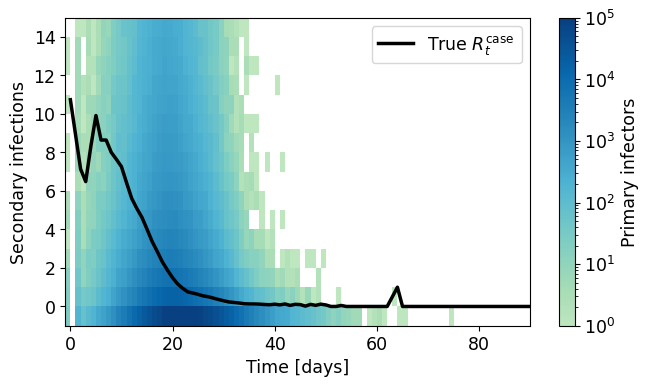

In [56]:
final_active_day = 90
active_times = np.arange(-0.5, final_active_day, 1)
frequencies = np.arange(-0.5, max_secondary_infections, 1)
fig, ax = plt.subplots(1, 1, figsize=(7.5, 4))
cmap_name = "GnBu"
whole_map = mpl.colormaps[cmap_name]
truncated_map = mpl.colors.LinearSegmentedColormap.from_list(f"{cmap_name}_subset",
                                                             whole_map(np.linspace(0.3, 1.0, 100)))
cf = ax.pcolormesh(active_times, frequencies, contingency_array[:, :final_active_day + 1],
                   alpha=1, cmap=truncated_map,
                   norm=mpl.colors.LogNorm())
cf.set_clim(1, 1e5)
ax.plot(secondary_infections_data["time"][:final_active_day + 1], 
        true_Rt[:final_active_day + 1], 'k', 
        lw=2.5, label="True $R_t^{\\mathrm{case}}$")
fig.colorbar(cf, label="Primary infectors")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Secondary infections")
# ax.set_title("Distribution of secondary infections over time")
ax.legend()
fig.savefig(f"NI_outputs/{radius}/secondary_infections_E_mesh.png", bbox_inches="tight")

### Compartmental plots

Here, we use our 1000 samples to plot the compartmental values.

In [57]:
mpl.rcParams.update({'font.size': 15})

In [ ]:
# truncated_times = np.arange(0, len(susceptible), 0.01)
# times = np.arange(0, len(susceptible), 0.01)

In [58]:
import random
num_samples = 1000
pints_model._n_outputs = 4
SEIR_lists = [[], [], [], []]
beta_samples, kappa_samples, gamma_samples = [], [], []
for j in range(num_samples):
    k = random.randint(0, len(beta_posterior))
    beta, kappa, gamma = beta_posterior[k], kappa_posterior[k], gamma_posterior[k]
    # Note that below, the name "beta" refers to the parameter "kappa" AHHHHH
    # beta, kappa, gamma = beta_posterior[k], fixed_hyperparams["beta"], fixed_hyperparams["gamma"]
    beta_samples.append(beta)
    kappa_samples.append(kappa)
    gamma_samples.append(gamma)
    # seir_data = pints_model.simulate([beta], truncated_times)
    seir_data = pints_model.simulate([beta, kappa, gamma], truncated_times)
    for i in range(len(SEIR_lists)):
        SEIR_lists[i].append(seir_data[:, i])
lower_bounds = []
means = []
upper_bounds = []
for SEIR_list in SEIR_lists:
    SEIR_np = np.array(SEIR_list)
    lower_bounds.append(np.percentile(SEIR_np, 2.5, axis=0) * pop_size)
    means.append(np.mean(SEIR_np, axis=0) * pop_size)
    upper_bounds.append(np.percentile(SEIR_np, 97.5, axis=0) * pop_size)

And here we make the plots.

In [ ]:
# less_times = np.arange(0, len(susceptible), 1)

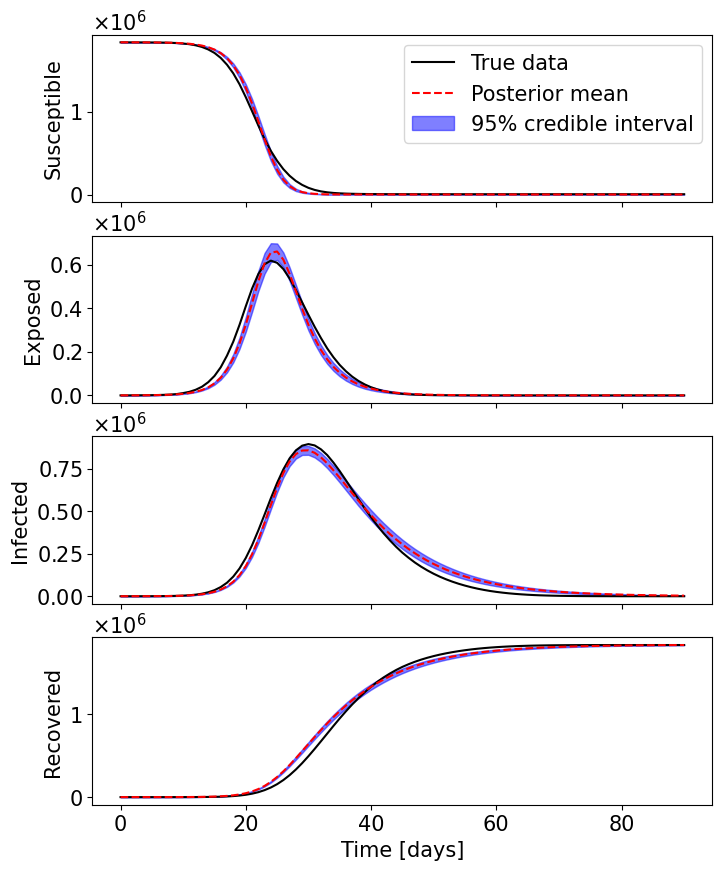

In [59]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 30/3), sharex=True)
lower_t, upper_t = 0, 91
true_data = [susceptible[lower_t:upper_t], exposed[lower_t:upper_t], infected[lower_t:upper_t], recovered[lower_t:upper_t]]
ylabels = ["Susceptible", "Exposed", "Infected", "Recovered"]
for i in range(4):
    ax = axs[i]
    # ax.plot(less_times, true_data[i], "-k", label="True data")
    ax.plot(times, true_data[i], "-k", label="True data")
    ax.plot(times, means[i], "--r", label="Posterior mean")
    ax.fill_between(times, lower_bounds[i], upper_bounds[i], alpha=0.5,
                    label="95% credible interval", color="blue")
    if i == 0:
        ax.legend(loc='upper right')
    elif i == 3:
        ax.set_xlabel("Time [days]")
    ax.set_ylabel(ylabels[i])
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.yaxis.get_major_formatter().set_powerlimits((0, 0))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(6, 6), useMathText=True)
    # ax.set_ylim(0, 2e6)
# fig.suptitle("Inferred SEIR curves: Case 1")
fig.savefig(f"inference_outputs/{radius}/{trial}/inferred_SEIR_CI.png")

### Cloud of trajectories

Alternatively, if we do not converge to a unimodal posterior (as is the case with the inference of all four compartments for $r = 0.2$ case, we will just plot a cloud of $50$ trajectories to show the different modes that can be achieved).

In [ ]:
mpl.rcParams.update({'font.size': 10})

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 30/3), sharex=True)
lower_t, upper_t = 0, 91
true_data = [susceptible[lower_t:upper_t], exposed[lower_t:upper_t], infected[lower_t:upper_t], recovered[lower_t:upper_t]]
ylabels = ["Susceptible", "Exposed", "Infected", "Recovered"]
colours = ["blue", "forestgreen", "goldenrod", "firebrick"]
for i in range(4):
    ax = axs[i]
    SEIR_list = SEIR_lists[i][:50]
    for j, trajectory in enumerate(SEIR_list):
        if j == 0:
            ax.plot(truncated_times, np.array(trajectory) * pop_size, color=colours[i], alpha=0.15, label="Trajectories from posterior (n = 50)")
        else:
            ax.plot(truncated_times, np.array(trajectory) * pop_size, color=colours[i], alpha=0.15)
    ax.plot(times, true_data[i], "-k", label="True data", lw=2.5)
    if i == 3:
        ax.legend(loc='lower right')
        ax.set_xlabel("Time [days]")
    else:
        ax.legend(loc='upper right')
    ax.set_ylabel(ylabels[i])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(6, 6), useMathText=True)
    # ax.set_ylim(0, 2e6)
# fig.suptitle("Inferred SEIR curves: Case 1")
fig.savefig(f"inference_outputs/{radius}/{trial}/inferred_SEIR_cloud.png")

### Plotting expected and actual $R_t$ values

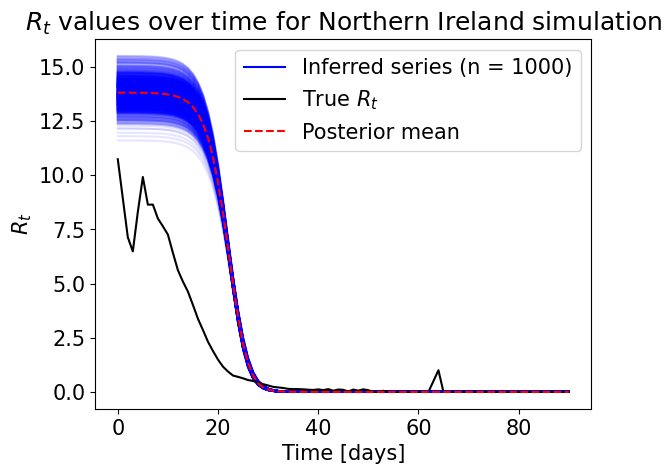

In [60]:
R_t_list = []
num_samples = 1000
for j in range(num_samples):
    # R_t_list.append(beta_samples[j] / (gamma_samples[j] * pop_size) * susceptible[:])
    R_t_list.append(beta_samples[j] / gamma_samples[j] * SEIR_lists[0][j])
    if j == 0:
        plt.plot(truncated_times[0:], R_t_list[j][:], 'b', label=f"Inferred series (n = {num_samples})")
    else:
        plt.plot(truncated_times[0:], R_t_list[j][:], 'b', alpha=0.1)
mean_R_t = np.mean(np.array(R_t_list), axis=0)
std_dev_R_t = np.std(np.array(R_t_list), axis=0)
# plt.plot(truncated_times[0:], secondary_infections_data["R_t"][20:61], 'k', 
#          label="True $R_t$")
plt.plot(times, secondary_infections_data["R_t"][:], 'k', 
         label="True $R_t$")
# plt.plot(less_times, secondary_infections_data["R_t"][:], 'k', 
#          label="True $R_t$")
plt.plot(truncated_times[0:], mean_R_t[:], '--r', label="Posterior mean")
plt.xlabel("Time [days]")
plt.ylabel("$R_t$")
plt.title("$R_t$ values over time for Northern Ireland simulation")
plt.legend()
# plt.colorbar(cf)
# plt.show()
plt.savefig(f"inference_outputs/{radius}/{trial}/inferred_R_t.png")

### Credible interval plot

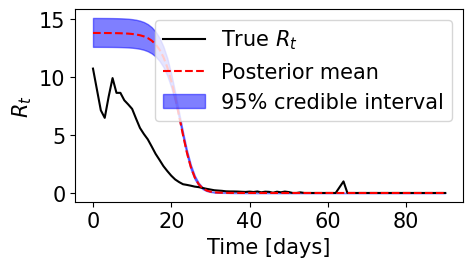

In [61]:
R_t_list = []
num_samples = 1000
for j in range(num_samples):
    # R_t_list.append(beta_samples[j] / (gamma_samples[j] * pop_size) * susceptible[:])
    R_t_list.append(beta_samples[j] / gamma_samples[j] * SEIR_lists[0][j])
mean_R_t = np.mean(np.array(R_t_list), axis=0)
std_dev_R_t = np.std(np.array(R_t_list), axis=0)
upper_R_t = np.percentile(np.array(R_t_list), 97.5, axis=0)
median_R_t = np.percentile(np.array(R_t_list), 50, axis=0)
lower_R_t = np.percentile(np.array(R_t_list), 2.5, axis=0)
# plt.plot(truncated_times[0:], secondary_infections_data["R_t"][20:61], 'k', 
#          label="True $R_t$")
plt.figure(figsize=(5, 2.5))
plt.plot(times, secondary_infections_data["R_t"][:], 'k', 
         label="True $R_t$")
plt.plot(truncated_times[:], mean_R_t[:], '--r', label="Posterior mean")
plt.fill_between(truncated_times[:], lower_R_t[:], upper_R_t[:], alpha=0.5,
                 label="95% credible interval", color="blue")
plt.xlabel("Time [days]")
plt.ylabel("$R_t$")
# plt.title("$R_t$ for Northern Ireland simulation: Case 1")
# plt.ylim(0, 15)
plt.legend()
# plt.colorbar(cf)
# plt.show()
plt.savefig(f"inference_outputs/{radius}/{trial}/inferred_R_t_CI.png", bbox_inches="tight")

In [62]:
mpl.rcParams.update({'font.size': 15})

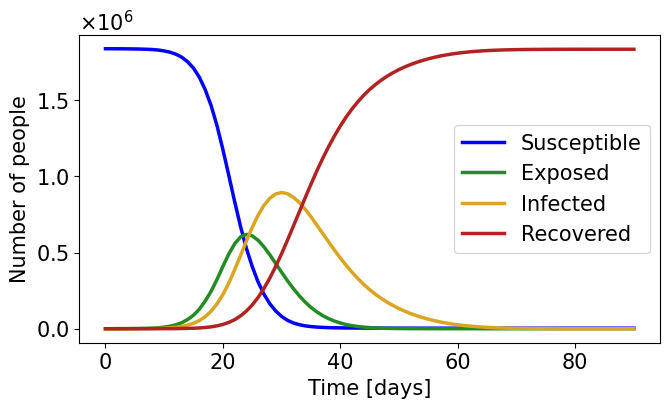

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 4))
ax.plot(times, susceptible, color="blue", label="Susceptible", lw=2.5)
ax.plot(times, exposed, color="forestgreen", label="Exposed", lw=2.5)
ax.plot(times, infected, color="goldenrod", label="Infected", lw=2.5)
ax.plot(times, recovered, color="firebrick", label="Recovered", lw=2.5)
ax.legend()
ax.set_xlabel("Time [days]")
ax.set_ylabel("Number of people")
ax.ticklabel_format(axis='y', style='sci', scilimits=(6, 6), useMathText=True)
# plt.title("Compartmental data for Northern Ireland simulation with r = 0.2")
fig.savefig(f"NI_outputs/{radius}/SEIR.png", bbox_inches="tight")

### Comparing the inferred serial interval/generation time to true distributions

In this section, we estimate the serial interval/generation time (using the same formula):

\begin{equation}
    g(t) = \frac{\kappa\gamma}{\kappa - \gamma}\left(e^{-\gamma t} - e^{-\kappa t}\right)
\end{equation}

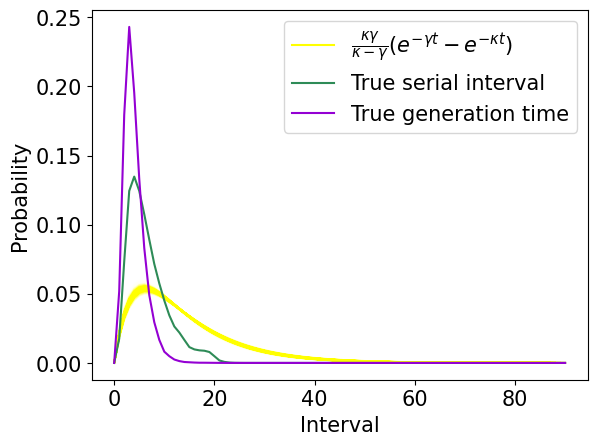

In [64]:
fig, ax = plt.subplots()
serial_interval_samples = []
alternative_samples = []
for j in range(num_samples):
    kap, gam = kappa_samples[j], gamma_samples[j]
    serial_interval_samples.append(kap * gam / (kap - gam) * (np.exp(-gam * times) - np.exp(-kap * times)))
    alternative_samples.append(gam * np.exp(-gam * times))
    if j == 0:
        ax.plot(times, serial_interval_samples[j], color="yellow", alpha=1, label="$\\frac{\\kappa\\gamma}{\\kappa - \\gamma}\\left(e^{-\\gamma t} - e^{-\\kappa t}\\right)$")
        # ax.plot(times, alternative_samples[j], color="deepskyblue", alpha=1, label="$\\gamma e^{-\\gamma t}$")
    else:
        ax.plot(times, serial_interval_samples[j], color="yellow", alpha=0.01)
        # ax.plot(times, alternative_samples[j], color="deepskyblue", alpha=1)
ax.plot(times, serial_interval_pdf, color="seagreen", label="True serial interval")
ax.plot(times, generation_time_pdf, color="darkviolet", label="True generation time")
# ax.plot(less_times, serial_interval_pdf, color="seagreen", label="True serial interval")
# ax.plot(less_times, generation_time_pdf, color="darkviolet", label="True generation time")
ax.legend()
ax.set_xlabel("Interval")
ax.set_ylabel("Probability")
serial_interval_seir = np.array(serial_interval_samples)
alt_serial_interval_seir = np.array(alternative_samples)
# print(np.mean(serial_interval_seir, axis=0))
fig.savefig(f"inference_outputs/{radius}/{trial}/ser_int_gen_time_sampled.png", bbox_inches="tight")

In [65]:
estimated_gen_time = pd.DataFrame({"Time": times, "Generation time": np.mean(serial_interval_seir, axis=0)})
estimated_gen_time.to_csv(f"inference_outputs/{radius}/{trial}/estimated_gen_time.csv")

## Converting instantaneous $R_{t}$ to case $R_{t}$

In their paper, Gostic et al. describe how to convert between the instantaneous $R_{t}$ (used in the SEIR ODE model) and the case $R_{t}$ (used as ground-truth in Epiabm) with the generation time probability distribution.

In [66]:
import scipy.integrate as si

In [67]:
def Rt_inst_to_Rt_case(Rt_inst, w, t_start, t_end, dt=1, w_percentile=None):
    """Converts the instantaneous reproduction number to the case reproduction number
    at time t, given a generation time/serial interval distribution, w. If a w_percentile
    is specified, we only calculate Rt_case up until T - w_width days, where T is the
    total length of the simulation, and w_width is the length of the w array which contains
    (w_percentile * 100)% of the probability of w.
    """
    T = int((t_end - t_start) / dt)
    len_Rt_case = T
    if w_percentile is not None:
        w_cumul = np.array([np.sum(w[:i + 1]) for i in range(len(w))])
        w_width = np.argmax(w_cumul >= w_percentile)
        len_Rt_case -= w_width
    Rt_case = []
    for t in range(len_Rt_case):
        Rt_inst_arr = Rt_inst[t:]
        w_arr = w[:T - t]
        Rt_case_t = np.sum(Rt_inst_arr * w_arr)
        Rt_case.append(Rt_case_t)
    return Rt_case

In [68]:
case_Rt_list = []
for j in range(num_samples):
    case_Rt_sample = []
    if sampling_intervals:
        inst_Rt = [0] * (upper_t - lower_t)
        # Assigning the different Rt values to their correct timepoints
        i_start = 0
        for pair in sampling_intervals:
            inst_Rt[pair[0]:pair[1]] = R_t_list[j][i_start:i_start + pair[1] - pair[0]]
            i_start += pair[1] - pair[0]
        # Filling the gaps using linear interpolation
        for gap_num in range(len(sampling_intervals) - 1):
            left, right = sampling_intervals[gap_num][1], sampling_intervals[gap_num + 1][0]
            gap = right - left
            linear_spline = [inst_Rt[left - 1] + (inst_Rt[right] - inst_Rt[left - 1]) * (i + 1) / (gap + 1)
                             for i in range(gap)]
            inst_Rt[left:right] = linear_spline
        inst_Rt = np.array(inst_Rt)
    else:
        inst_Rt = R_t_list[j]
    case_Rt_sample = Rt_inst_to_Rt_case(inst_Rt, serial_interval_samples[j], lower_t, upper_t)
    case_Rt_list.append(case_Rt_sample)

## Creating metrics for $R_{t}$ comparison

Next, we create three quantitative metrics for comparing a true $R_{t}$ curve to a series of inferred $R_{t}$ curves (which have posterior means and 95% credible intervals). These are listed below, and have units of % similarity:

|Metric|Description|
|---|-------|
|I|The percentage of timepoints for which the true $R_{t}$ curve lies within the 95% credible interval of the inferred $R_{t}$.|
|II|The percentage of timepoints for which the true $R_{t}$ and posterior mean $R_{t}$ agree as to whether $R_{t} > 1$ (growing) or $R_{t} \leq 1$ (decaying).|
|III|The percentage of timepoints for which the true $R_{t}$ and posterior $R_{t}$ confidently agree to the above condition. This means that the whole credible interval must lie above or below one for the timepoint to yield a positive result.|

In [69]:
def calculate_Rt_similarity_I(true_Rt: np.array, lower_inferred_Rt: np.array, upper_inferred_Rt: np.array):
    """Calculates the percentage of timesteps in which true_Rt lies between lower_inferred_Rt and upper_inferred_Rt.
    """
    count = 0
    for i in range(len(true_Rt)):
        if true_Rt[i] >= lower_inferred_Rt[i] and true_Rt[i] <= upper_inferred_Rt[i]:
            count += 1
    return count / len(true_Rt) * 100

In [70]:
def calculate_Rt_similarity_II(true_Rt: np.array, mean_inferred_Rt: np.array):
    """Calculates the percentage of timesteps in which true_Rt and mean_Rt agree as to whether Rt > 1 or Rt <= 1.
    """
    count = 0
    for i in range(len(true_Rt)):
        a, b = true_Rt[i], mean_inferred_Rt[i]
        if (a > 1 and b > 1) or (a <= 1 and b <= 1):
            count += 1
    return count / len(true_Rt) * 100

In [71]:
def calculate_Rt_similarity_III(true_Rt: np.array, lower_inferred_Rt: np.array, upper_inferred_Rt: np.array):
    """Calculates the percentage of timesteps in which true_Rt and lower_inferred_Rt agree that Rt > 1 or 
    true_Rt and upper_inferred_Rt agree that Rt <= 1.
    """
    count = 0
    for i in range(len(true_Rt)):
        a, b, c = true_Rt[i], lower_inferred_Rt[i], upper_inferred_Rt[i]
        if (a > 1 and b > 1) or (a <= 1 and c <= 1):
            count += 1
    return count / len(true_Rt) * 100

## Comparing case $R_{t}$ curves

In [72]:
use_stored_data = False

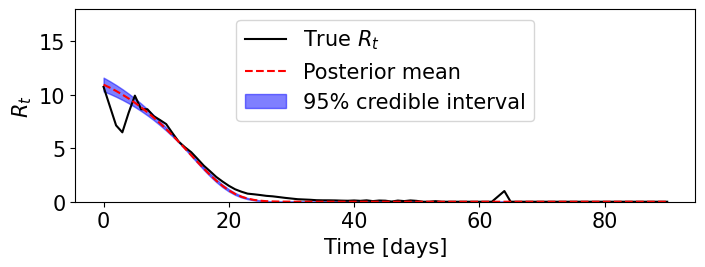

In [73]:
if use_stored_data:
    Rt_df_read = pd.read_csv(f"inference_outputs/{radius}/{trial}/Rt.csv", index_col=0)
    # times_ = Rt_df_read["Time"]
    true_Rt = Rt_df_read["True Rt"]
    lower_Rt = Rt_df_read["Lower Rt (2.5%)"]
    mean_Rt = Rt_df_read["Mean Rt"]
    upper_Rt = Rt_df_read["Upper Rt (97.5%)"]
else:
    mean_Rt = np.mean(np.array(case_Rt_list), axis=0)
    std_dev_Rt = np.std(np.array(case_Rt_list), axis=0)
    upper_Rt = np.percentile(np.array(case_Rt_list), 97.5, axis=0)
    median_Rt = np.percentile(np.array(case_Rt_list), 50, axis=0)
    lower_Rt = np.percentile(np.array(case_Rt_list), 2.5, axis=0)
case_Rt_times = times[:len(mean_Rt)]
# plt.plot(truncated_times[0:], secondary_infections_data["R_t"][20:61], 'k', 
#          label="True $R_t$")
plt.figure(figsize=(8, 2.5))
# plt.plot(less_times, true_Rt[:], 'k', 
#          label="True $R_t$")
plt.plot(case_Rt_times, true_Rt[:len(mean_Rt)], 'k', 
         label="True $R_t$")
plt.plot(case_Rt_times, mean_Rt[:], '--r', label="Posterior mean")
plt.fill_between(case_Rt_times, lower_Rt[:], upper_Rt[:], alpha=0.5,
                 label="95% credible interval", color="blue")
plt.xlabel("Time [days]")
plt.ylabel("$R_t$")
# plt.title("Inferred $R_t$ for Northern Ireland simulation: Case 2")
# plt.ylim(0, 20)
plt.ylim(0, 18)
# plt.ylim(0, 16)
plt.legend(loc='upper center')
# plt.colorbar(cf)
# plt.show()
plt.savefig(f"inference_outputs/{radius}/{trial}/inferred_case_R_t_CI_sampled.png", bbox_inches="tight")

In [74]:
Rt_df = pd.DataFrame({"Time": times, "True Rt": true_Rt, "Lower Rt (2.5%)": lower_Rt, "Mean Rt": mean_Rt, "Upper Rt (97.5%)": upper_Rt})
Rt_df.to_csv(f"inference_outputs/{radius}/{trial}/Rt.csv")

In [75]:
print("R_t similarity metrics:")
similarity_I = calculate_Rt_similarity_I(true_Rt, lower_Rt, upper_Rt)
print(f"Metric I: {similarity_I:.2f}%")
similarity_II = calculate_Rt_similarity_II(true_Rt, mean_Rt)
print(f"Metric II: {similarity_II:.2f}%")
similarity_III = calculate_Rt_similarity_III(true_Rt, lower_Rt, upper_Rt)
print(f"Metric III: {similarity_III:.2f}%")

R_t similarity metrics:
Metric I: 6.59%
Metric II: 98.90%
Metric III: 97.80%


In [76]:
similarity_dict = {"Metric": ["I", "II", "III"], "Similarities": [similarity_I, similarity_II, similarity_III]}
similarity_df = pd.DataFrame(similarity_dict)
similarity_df.to_csv(f"inference_outputs/{radius}/{trial}/similarities.csv")

### Cloud of $R_{t}$ trajectories

As before, we may want to plot the cloud of $R_{t}$ trajectories if there is no clear unimodal distribution.

In [ ]:
mpl.rcParams.update({'font.size': 15})

In [ ]:
mean_R_t = np.mean(np.array(case_Rt_list), axis=0)
std_dev_R_t = np.std(np.array(case_Rt_list), axis=0)
upper_R_t = np.percentile(np.array(case_Rt_list), 97.5, axis=0)
median_R_t = np.percentile(np.array(case_Rt_list), 50, axis=0)
lower_R_t = np.percentile(np.array(case_Rt_list), 2.5, axis=0)
# plt.plot(truncated_times[0:], secondary_infections_data["R_t"][20:61], 'k', 
#          label="True $R_t$")
plt.figure(figsize=(8, 2.5))
plt.plot(times, secondary_infections_data["R_t"][:], 'k', 
         label="True $R_t$", lw=2.5)
for j, trajectory in enumerate(case_Rt_list[:50]):
    if j == 0:
        plt.plot(times, trajectory, color="darkviolet", alpha=0.15, label="Trajectories from posterior (n = 50)")
    else:
        plt.plot(times, trajectory, color="darkviolet", alpha=0.15)
plt.xlabel("Time [days]")
plt.ylabel("$R_t$")
# plt.title("Inferred $R_t$ for Northern Ireland simulation: Case 2")
# plt.ylim(0, 16)
plt.ylim(0, 20)
plt.legend(loc='upper right')
# plt.colorbar(cf)
# plt.show()
plt.savefig(f"inference_outputs/{radius}/{trial}/inferred_case_R_t_cloud.png", bbox_inches="tight")

## Plotting the branching process model data

Using the reproduction number reached using a renewal model (from Yunli Qi), we will now plot this data in the same style as the above curve for the case reproduction number.

In [77]:
radius = "r_1"

In [78]:
renewal_df = pd.read_csv(f"renewal_model/{radius}/Rt_210825.csv", index_col=0)

Here we make the inst -> case Rt conversion

In [79]:
times_rm = renewal_df["Time Points"].to_numpy() + 2
# lower_t, upper_t = times_rm[0] - 1, times_rm[-1]
# mean_Rt_rm = np.array(Rt_inst_to_Rt_case(renewal_df["Mean"], generation_time_pdf, lower_t, upper_t))
# upper_Rt_rm = np.array(Rt_inst_to_Rt_case(renewal_df["Upper bound CI"], generation_time_pdf, lower_t, upper_t))
# lower_Rt_rm = np.array(Rt_inst_to_Rt_case(renewal_df["Lower bound CI"], generation_time_pdf, lower_t, upper_t))
mean_Rt_rm = renewal_df["Mean"]
upper_Rt_rm = renewal_df["Upper bound CI"]
lower_Rt_rm = renewal_df["Lower bound CI"]
true_Rt_rm = renewal_df["True Rt"]

And here, we plot

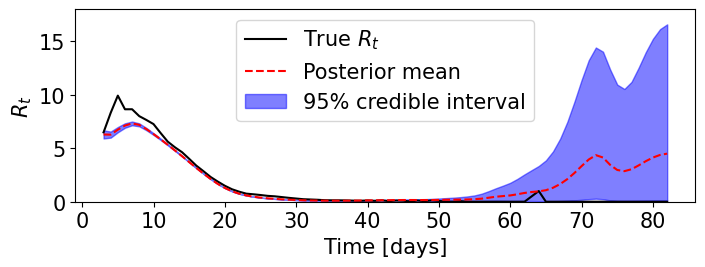

In [80]:
plt.figure(figsize=(8, 2.5))
plt.plot(times_rm, true_Rt_rm, 'k', 
         label="True $R_t$")
plt.plot(times_rm, mean_Rt_rm, '--r', label="Posterior mean")
plt.fill_between(times_rm, lower_Rt_rm, upper_Rt_rm, alpha=0.5,
                 label="95% credible interval", color="blue")
plt.xlabel("Time [days]")
plt.ylabel("$R_t$")
# plt.title("Inferred $R_t$ for Northern Ireland simulation: Case 2")
# plt.ylim(0, 20)
plt.ylim(0, 18)
plt.legend(loc='upper center')
# plt.colorbar(cf)
# plt.show()
plt.savefig(f"renewal_model/{radius}/inferred_Rt_210825.png", bbox_inches="tight")

In [81]:
print("R_t similarity metrics:")
similarity_I_rm = calculate_Rt_similarity_I(true_Rt_rm, lower_Rt_rm, upper_Rt_rm)
print(f"Metric I: {similarity_I_rm:.2f}%")
similarity_II_rm = calculate_Rt_similarity_II(true_Rt_rm, mean_Rt_rm)
print(f"Metric II: {similarity_II_rm:.2f}%")
similarity_III_rm = calculate_Rt_similarity_III(true_Rt_rm, lower_Rt_rm, upper_Rt_rm)
print(f"Metric III: {similarity_III_rm:.2f}%")

R_t similarity metrics:
Metric I: 10.00%
Metric II: 76.25%
Metric III: 67.50%


In [82]:
similarity_dict_rm = {"Metric": ["I", "II", "III"], "Similarities": [similarity_I_rm, similarity_II_rm, similarity_III_rm]}
similarity_df_rm = pd.DataFrame(similarity_dict_rm)
similarity_df_rm.to_csv(f"renewal_model/{radius}/similarities.csv")